# huh... computer music

#### A small library for creating computer music using Numpy.

Or...

![python as an instrument](./image.png)

In [ ]:
"""
housekeeping...
"""

%matplotlib notebook
from matplotlib import pyplot as plt

import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    

import hcm

samples_dir = './samples'
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)

## Formalism

All audio signals are digital time series. A time series is just a list of values:

$ t = [t_{0}, t_{1}, t_{2}, ..., t_{n}, ..., t_{N}]$ 

A time series of duration `T` has `N` entries, indexed by n: `t[n]`. 

Time is discretized according to the sampling rate, which is the inverse of the time step $\operatorname{dt}$.  

In [6]:
"""
some useful preliminaries: define duration T, sample rate
"""

from hcm import time, sample_and_hold
from hcm import NOTES, KEYS

T = 60;                      # duration (in seconds)
sample_rate = 8000;          # (in samples per second)
t = time(0, T, sample_rate); # time is just np.linspace(0, T, num=sample_rate*T) 

f0 = NOTES['A4'];            # root note/lowest note in scale
key = KEYS['Mixolydian'];    # vector whose entries correspond 
num_octaves = 2;            

## oscillators

In [7]:
"""
basic three oscillators with fixed frequency
time is a 1-D array, frequency is a scalar
"""

from hcm import *
from hcm.io import wav_write


wav_write(f'{samples_dir}/sine_wave.wav', sample_rate, sine_wave)
wav_write(f'{samples_dir}/square_wave.wav', sample_rate, square_wave)
wav_write(f'{samples_dir}/triangle_wave.wav', sample_rate, triangle_wave)

<IPython.core.display.Javascript object>


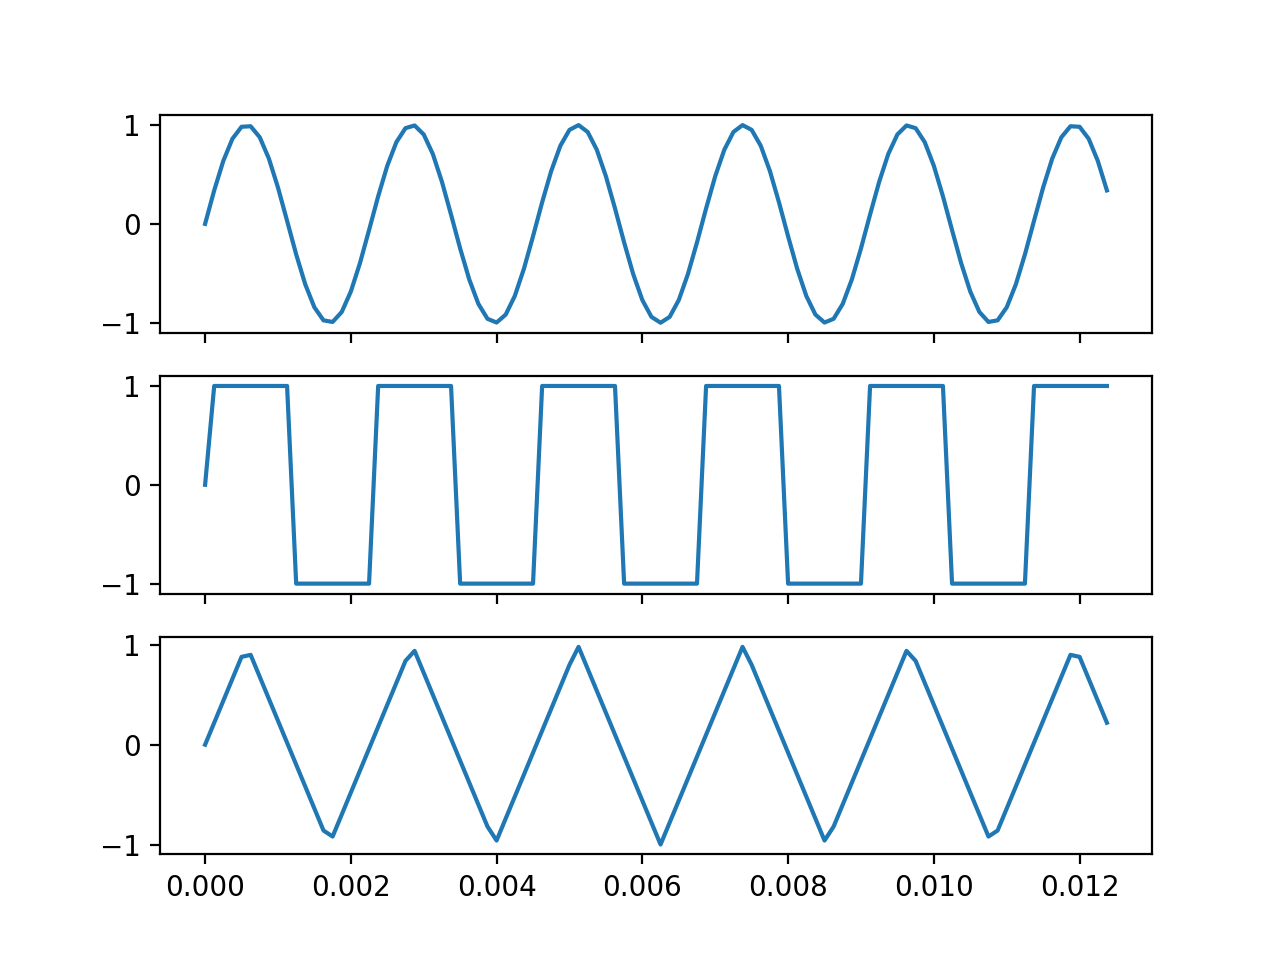

In [8]:
"""
plot basic oscillator waveforms 
"""
end = 100
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t[:end], sine_wave[:end])
ax2.plot(t[:end], square_wave[:end])
ax3.plot(t[:end], triangle_wave[:end])

But oscillators with fixed frequencies are not so interesting on their own. We might want an oscillator whose frequency we can control by an external signal. In the parlance of modular synthesis, we want a voltage controlled oscillator (VCO). VCO takes three arguments: time, frequency, and oscillator type. Frequency is now an array, so that it can now be a function of time. 

<IPython.core.display.Javascript object>


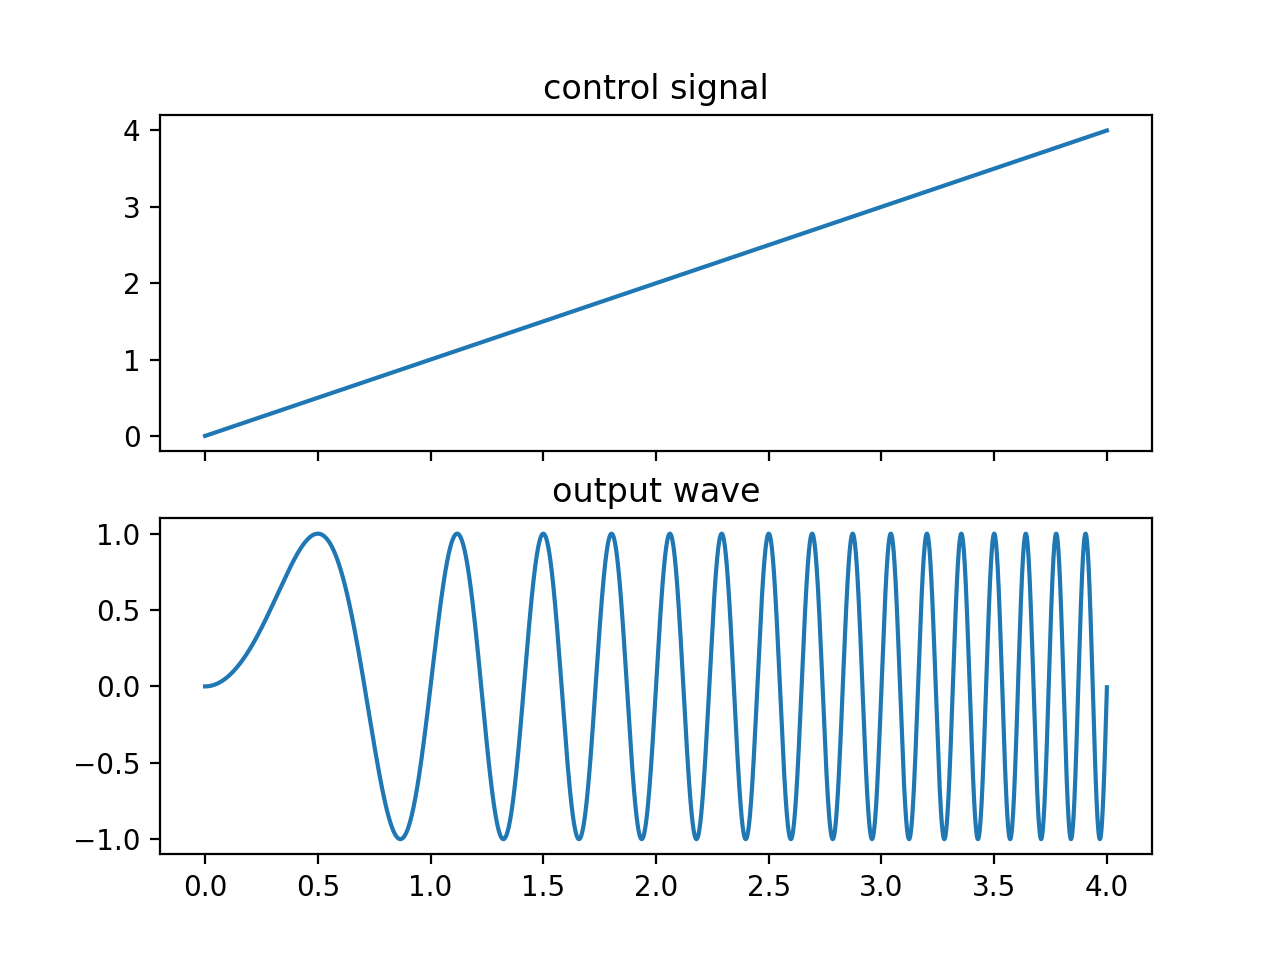

Text(0.5,1,'output wave')

In [94]:
"""
voltage-controlled oscillator with varying control signals
"""
from hcm import VCO

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
vco_end = sample_rate*4


control = t
# control = np.ones(len(t))*2
# control = t*t
# control = (t-2)*(t-2)
x = VCO(t, control, sine)
# x = VCO(t, control, triangle)

ax1.plot(t[:vco_end], control[:vco_end])
ax1.set_title('control signal')
ax2.plot(t[:vco_end], x[:vco_end])
ax2.set_title('output wave')

<IPython.core.display.Javascript object>


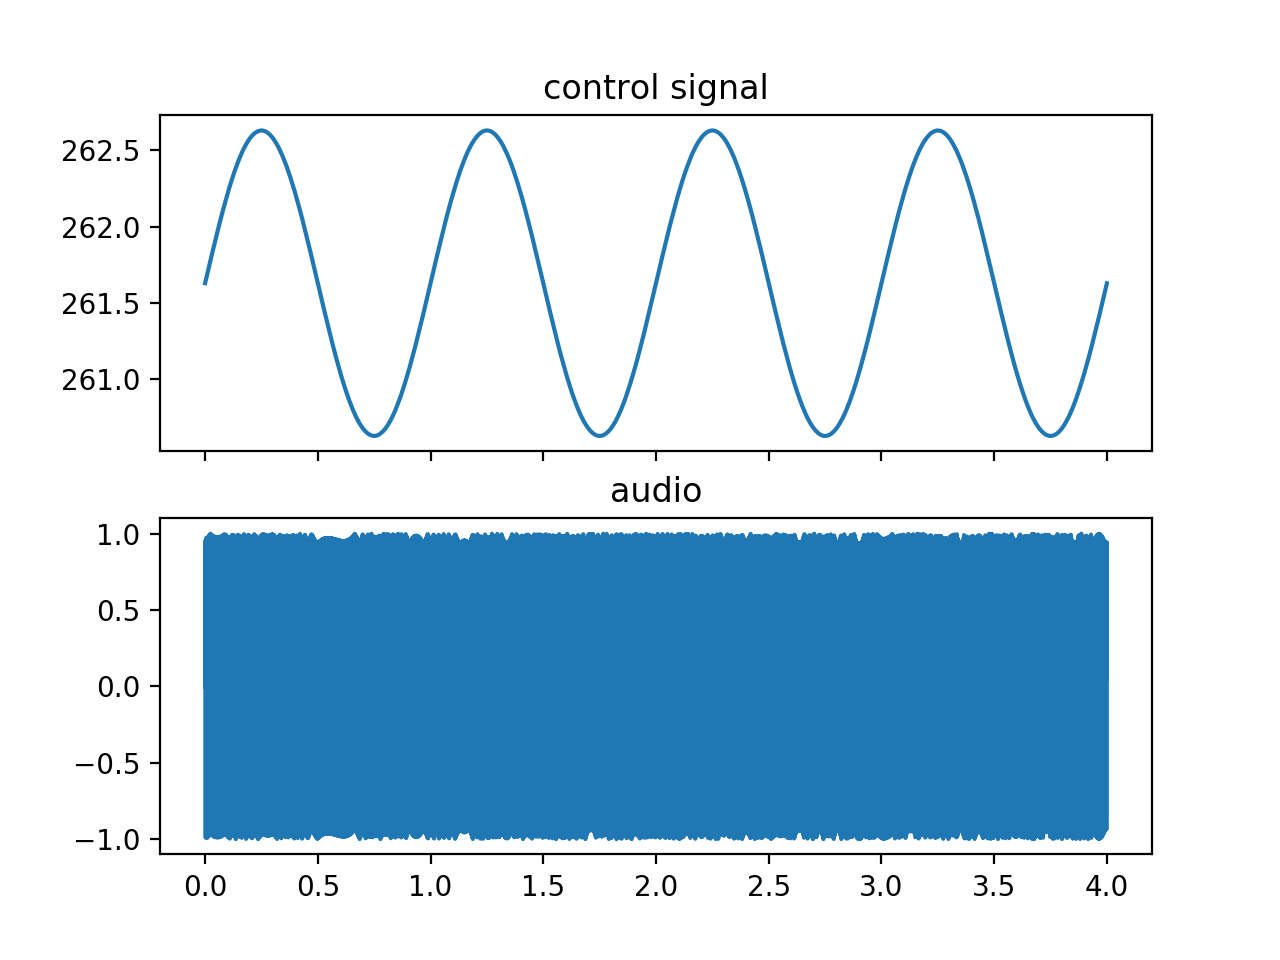

In [95]:
"""
voltage-controlled oscillator applied to sine wave (a pure tone)
control signal is a traingle wave. 

the frequency should go up and down periodically. 
"""

vco_end = sample_rate * 4

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

control = f0+sine(t, 1)

x = VCO(t, control, triangle)
ax1.plot(t[:vco_end], control[:vco_end])
ax1.set_title('control signal')
ax2.plot(t[:vco_end], x[:vco_end])
ax2.set_title('audio')

wav_write(f'{samples_dir}/wavy_vco.wav', sample_rate, x)

## towards music: mapping VCOs to notes on a scale

A continuous timeseries is often not desireable for making music. We would rather have a particular note take a longer duration, especially when applying a VCO to a signal. In addition, we'd like to map control signals to notes on a scale instead of do the pain staking math to make our music sound pleasing. 

Thus, HCM provides a function a few functions to make music making easier. 

<IPython.core.display.Javascript object>


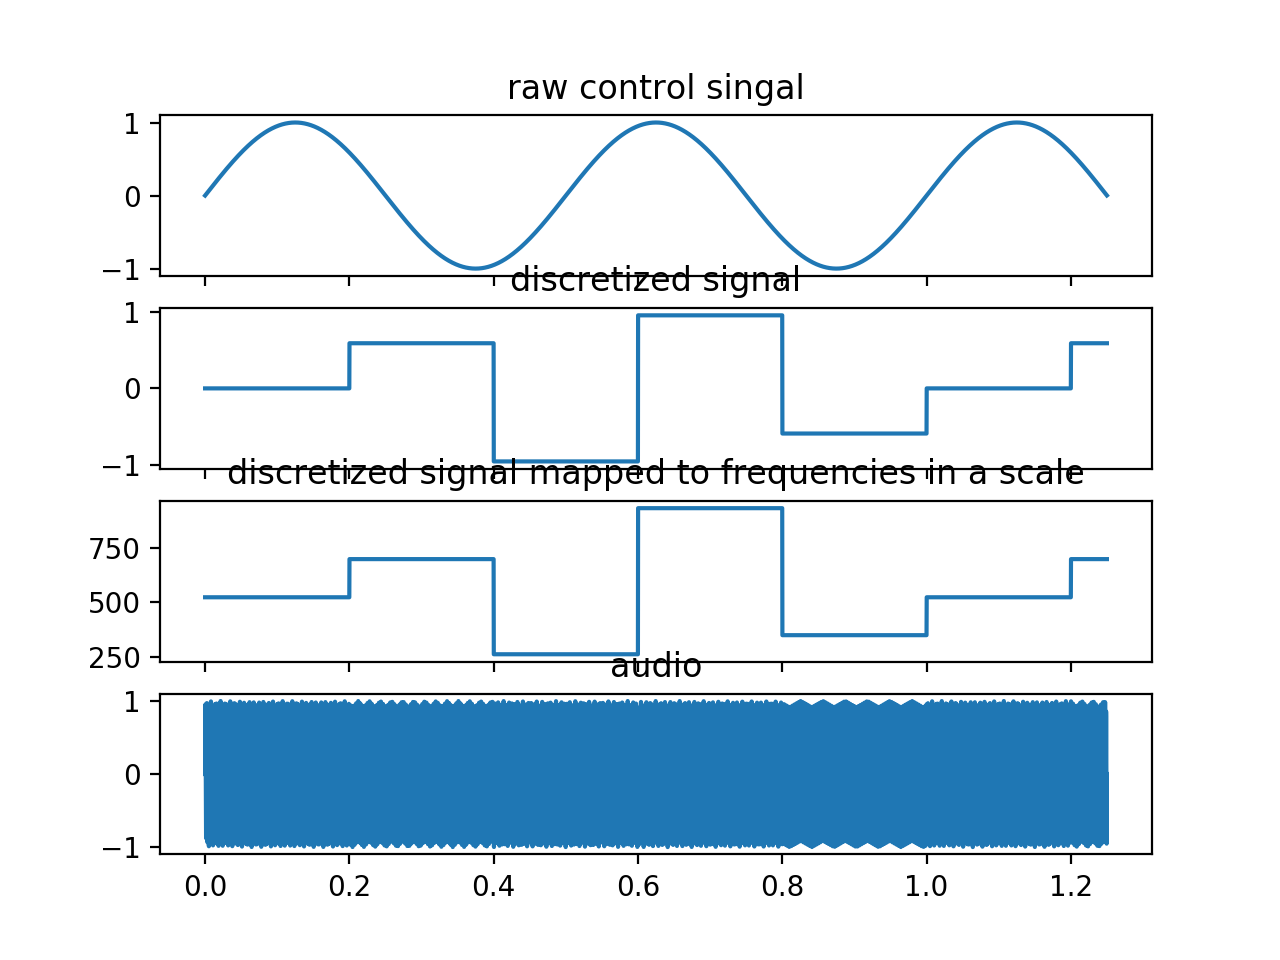

In [93]:
from hcm import sample_and_hold, time
from hcm import scale_constructor, tempo_to_frequency, frequency_map
map_start = 0 # 1000*9
map_end = 1000*10

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)


f0 = NOTES['C4']
key = KEYS['Mixolydian']
num_octaves = 2
scale = scale_constructor(f0, key, num_octaves)

sine_wave = sine(t, 2)
# sine_wave = sine(t, f0)

hold = tempo_to_frequency(150, 'eighth')
x = sample_and_hold(sine_wave, sample_rate, hold)
fx = frequency_map(x, scale)
X = VCO(t, fx, triangle)

ax1.plot(t[map_start:map_end], sine_wave[map_start:map_end])
ax1.set_title('raw control singal')
ax2.plot(t[map_start:map_end], x[map_start:map_end])
ax2.set_title('discretized signal')
ax3.plot(t[map_start:map_end], fx[map_start:map_end])
ax3.set_title('discretized signal mapped to frequencies in a scale')
ax4.plot(t[map_start:map_end], X[map_start:map_end])
ax4.set_title('audio')
wav_write(f'{samples_dir}/basic_notes.wav', sample_rate, X)

## noise 

White noise is obtained by sampling random numbers on the interval [-1.0, 1.0] from a random uniform distribution.

In [12]:
from hcm import white_noise

noise = white_noise(t)
wav_write(f'{samples_dir}/white_noise.wav', sample_rate, noise)

Brown noise is obtained by simulating a Brownian motion. Observe that the Brownian motion wanders off from the origin, which is something that needs to be addressed. Perhaps if x exceeds some threshold, it gets reset to 0, or something like that. 

In [20]:
from hcm import brownian_noise
from hcm import normalize 

brownian = brownian_noise(t)
# brownian = normalize(brownian)
wav_write(f'{samples_dir}/brownian_noise.wav', sample_rate, brownian)

<IPython.core.display.Javascript object>


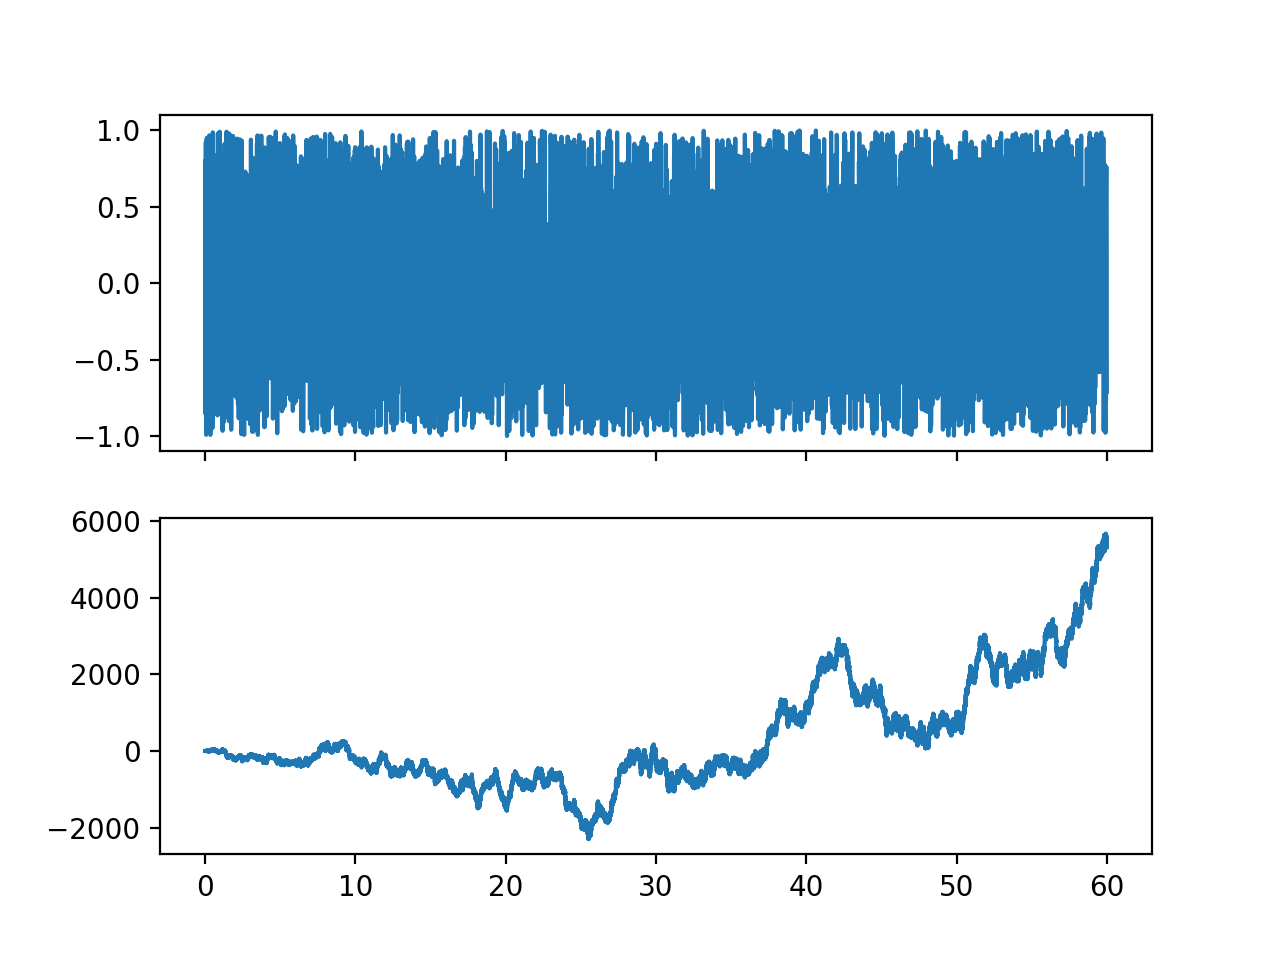

In [21]:
# plot of each of the respective noise signals
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t[0::100], noise[0::100])
ax2.plot(t, brownian)

In [109]:
"""
quick test of mapping brownian motion into notes.
"""

from hcm import normalize 

hold = tempo_to_frequency(150, 'quarter')
f0 = notes['C4']
key = keys['Mixolydian']
num_octaves = 2
scale = scale_constructor(f0, key, num_octaves)


CV = normalize(sample_and_hold(brownian_noise(t), sample_rate, hold))
freq = frequency_map(CV, scale)
x = VCO(t, freq, sine)
wav_write(f'{samples_dir}/brownian_song.wav', sample_rate, x)

In [96]:
"""
from all of the above, we can create a purely random song. 
"""
from hcm import normalize 
from datetime import datetime 

sample_rate = 8000
T = 60
t = time(0, T, sample_rate)

f0 = notes['C4']
key = keys['Chromatic']
scale = scale_constructor(f0, key, 2)

signal = np.zeros(len(t))

N = 4
for i in range(N):
    note_duration = np.random.choice(['whole', 'half', 'quarter', 'eighth', 'sixteenth'])
    hold = tempo_to_frequency(150, note_duration)
    CV = sample_and_hold(white_noise(t), sample_rate, hold)
    freq = frequency_map(CV, scale)
    x = VCO(t, freq, sine)
    signal = signal + x

signal = normalize(signal)

wav_write(f'{samples_dir}/random_song_{datetime.now()}.wav', sample_rate, signal)

## lorenz system

The exemplar chaotic dynamical system. Three coupled nonlinear ordinary differential equations we can get away integrating by Euler's method because the time steps are very small. 

<IPython.core.display.Javascript object>


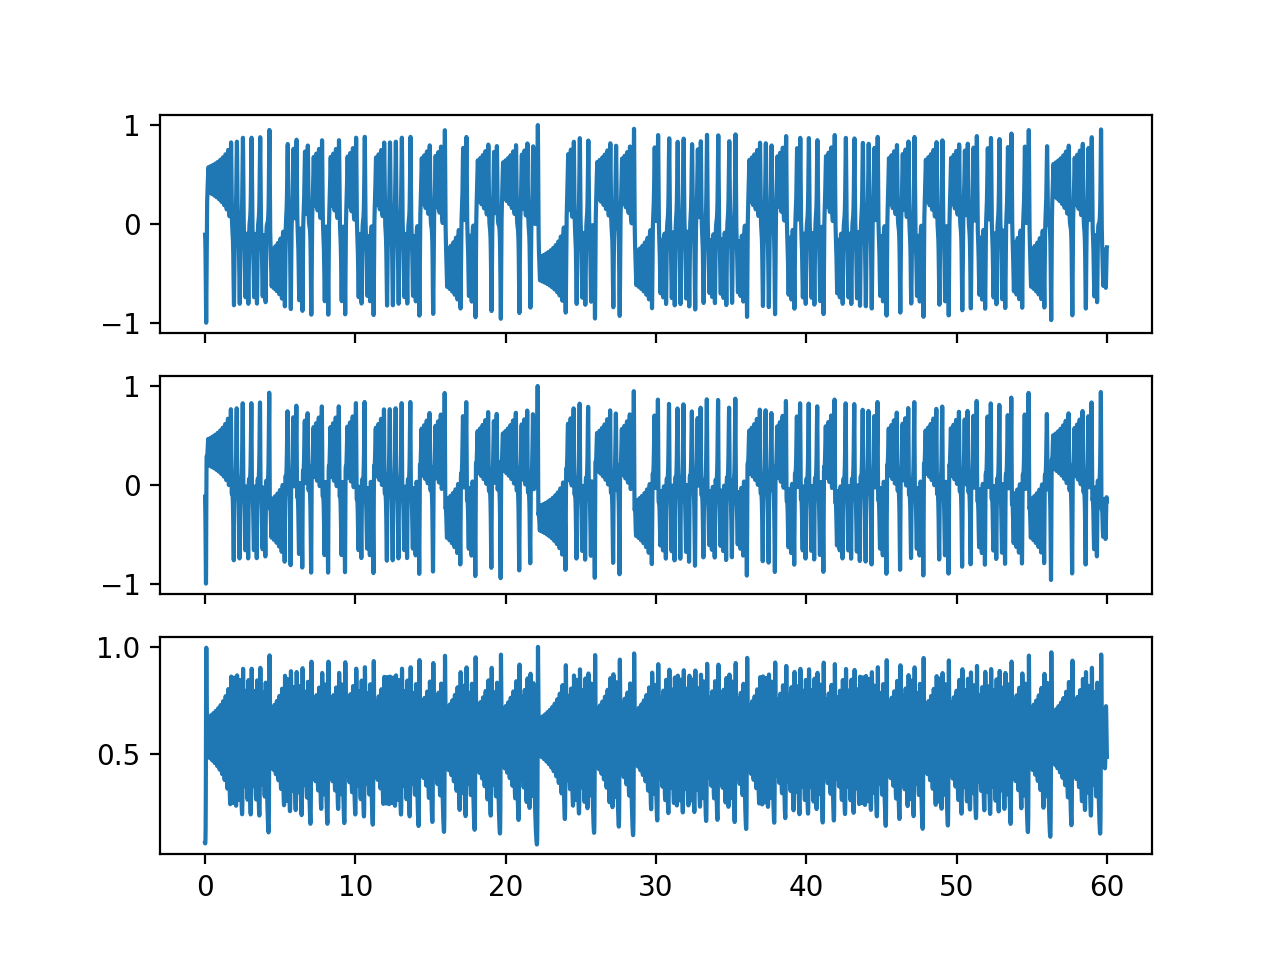

<IPython.core.display.Javascript object>


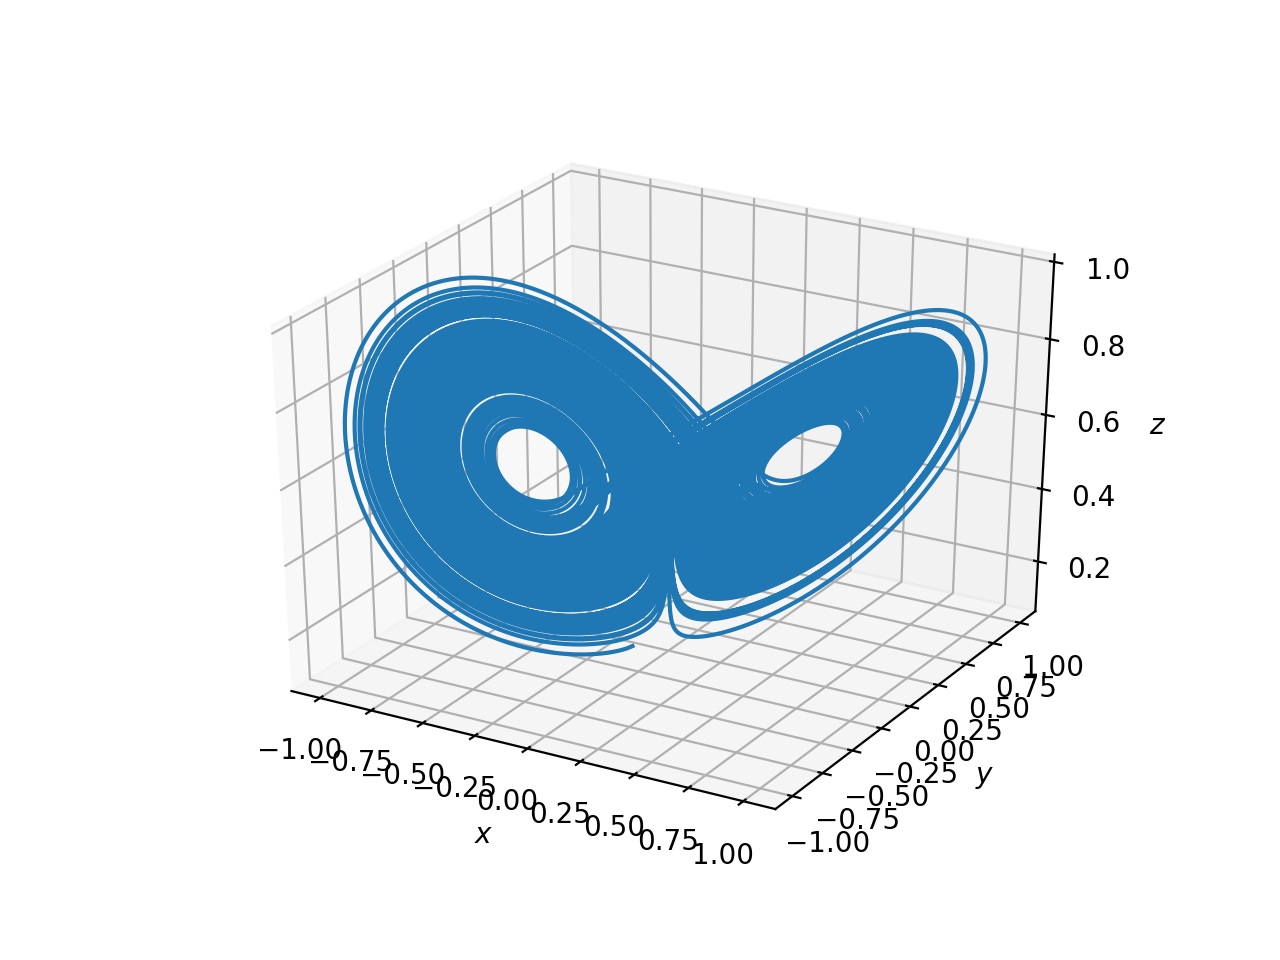

In [15]:
from hcm.dynamical import lorenz

time_scale = 4; # workable values for this fudge factor lie in the range ...
soln = lorenz(t, time_scale=time_scale)

x = soln[0]
y = soln[1]
z = soln[2]

# plot basic oscillator waveforms 
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t, x)
ax2.plot(t, y)
ax3.plot(t, z)


# plot first three variables
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

There are many potential uses for these signals: with the right value of time_scale, they can be heard themselves, although the signals are not particularly pleasant on their own. As modulating signals, they can perform admirably in gating amplitudes of oscillators tuned to musical notes, or making wobbly noises by controlling the frequencies of oscillators. 

More interestingly, the values of each variable can be mapped to positions on a musical scale, and the Lorenz system will spit out pleasant melodies. 

Also notice in the phase plot that there are two distinct basins of attraction. The system switches from one strange attractor to the other whenever x changes sign. This can be used to encode things like chord changes. 

In [97]:
from hcm import sample_and_hold, time
from hcm import NOTES, KEYS
from hcm import scale_constructor, tempo_to_frequency, frequency_map
from hcm.io import add_channels

sample_rate = 8000
T = 60
t = time(0, T, sample_rate)

f0 = NOTE['C4']
key = KEYS['Mixolydian']
num_octaves = 2
scale = scale_constructor(f0, key, num_octaves)

time_scale = 4; # workable values for this fudge factor lie in the range ...
soln = lorenz(t, time_scale=time_scale)

hold = tempo_to_frequency(150, 'eighth')
x = sample_and_hold(soln[0], sample_rate, hold)
y = sample_and_hold(soln[1], sample_rate, hold)
z = sample_and_hold(soln[2], sample_rate, hold)

fx = frequency_map(x, scale)
fy = frequency_map(y, scale)
fz = frequency_map(z, scale)


X = VCO(t, fx, triangle)
Y = VCO(t, fy, triangle)
Z = VCO(t, fz, triangle)

wav_write(f'{samples_dir}/test_lorenz_6.wav', sample_rate, add_channels((X,Y,Z)))

In [52]:
"""
what does lorenz sound like without sampling and holding (i.e. the continuous output)?
"""


x = soln[0]
y = soln[1]
z = soln[2]

fx = frequency_map(x, scale)
fy = frequency_map(y, scale)
fz = frequency_map(z, scale)


X = VCO(t, fx, triangle)
Y = VCO(t, fy, triangle)
Z = VCO(t, fz, triangle)

wav_write(f'{samples_dir}/test_lorenz_5.wav', sample_rate, add_channels((X,Y,Z)))

In [98]:
"""
what does lorenz sound like with amplitude modulation (i.e. voltage-controlled amplitude)?
See adsr
"""

from hcm import VCA

XAM = VCA(x, X)
YAM = VCA(y, Y)
ZAM = VCA(z, Z)

wav_write(f'{samples_dir}/test_lorenz2.wav', sample_rate, (XAM+YAM+ZAM)/3)

In [103]:
soln = lorenz(t, time_scale=1)

x = sample_and_hold(soln[0], sample_rate, sample_rate)
y = sample_and_hold(soln[1], sample_rate, sample_rate)
z = sample_and_hold(soln[2], sample_rate, sample_rate)

fx = frequency_map(x, scale)
fy = frequency_map(y, scale)
fz = frequency_map(z, scale)

X = VCO(t, fx, triangle)
Y = VCO(t, fy, triangle)
Z = VCO(t, fz, triangle)


G = VCA(x, triangle(t, notes['G4'])) 
E = VCA(y, triangle(t, notes['E4']))
Bb = VCA(z, triangle(t, notes['Bb4']))

wav_write(f'{samples_dir}/test_lorenz.wav', sample_rate, add_channels((X+Y+Z, G+E+Bb)))

## comp lorenze no. 1

In [107]:
from hcm import tempo_to_frequency as bpm2f
from hcm import frequency_map as qf
from hcm import scale_constructor as scale
from hcm import sample_and_hold as sh
from hcm import VCO, VCA
from datetime import datetime

T = 55
R = 8000
t = time(0, T, R)


def perturber(X0, sensitivity=0.1):
    eps = sensitivity * np.random.choice([-1,1]) * np.random.rand()
    coord = np.random.choice([0,1,2])
    X0[coord] = X0[coord] + eps
    return X0

initial_conditions = [2,3,4]
# initial_conditions = perturber([2,3,4],sensitivity=.5)

print(f'Initial conditions: {initial_conditions}')
x,y,z = lorenz(t, X0=initial_conditions, time_scale=.5)


hx = bpm2f(60, 'sixteenth')
hy = bpm2f(60, 'eighth')
hz = bpm2f(60, 'sixteenth')

fx = scale(f0=notes['C3'], key=keys['Mixolydian'], num_octaves=3)
fy = scale(f0=notes['C3'], key=keys['Mixolydian'], num_octaves=3)
fz = scale(f0=notes['C3'], key=keys['Mixolydian'], num_octaves=3)


v1 = VCA(VCO(t, qf(sh(x, R, hx), fx), osc=triangle), x)
v2 = VCA(VCO(t, qf(sh(y, R, hy), fy), osc=triangle), y)
v3 = VCA(VCO(t, qf(sh(z, R, hz), fz), osc=triangle), z)


ch1 = (v1+0.5*v3)/2
ch2 = (v2+0.5*v3)/2
out = add_channels((ch1,ch2))

wav_write(f'{samples_dir}/comp_lorenz_no_1_{str(datetime.now())}.wav', R, out)

Initial conditions: [2, 3.3797384917722226, 4]
